In [1]:
%env CUDA_VISIBLE_DEVICES=3
%env LIBRARY_PATH=/usr/local/cuda/lib64
import sys
import os
sys.path.append(os.path.expanduser("~/.local/lib/python3.6/site-packages/"))

env: CUDA_VISIBLE_DEVICES=3
env: LIBRARY_PATH=/usr/local/cuda/lib64


__This seminar__ teaches you about metric learning for NLP.

In [2]:
import json
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/shirobokov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Stanford question answering dataset (SQuAD)

_this seminar is based on original notebook by [Oleg Vasilev](https://github.com/Omrigan/)_

Today we are going to work with a popular NLP dataset.

Here is the description of the original problem:

```
Stanford Question Answering Dataset (SQuAD) is a new reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage. With 100,000+ question-answer pairs on 500+ articles, SQuAD is significantly larger than previous reading comprehension datasets.
```


We are not going to solve it :) Instead we will try to answer the question in a different way: given the question, we will find a **sentence** containing the answer, but not within the context, but in a **whole databank**

In [3]:
# download the data
#!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json

--2018-04-29 23:55:57--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30288272 (29M) [application/json]
Saving to: ‘train-v1.1.json.1’

train-v1.1.json.1   100%[===================>]  28.88M  61.0MB/s    in 0.5s    

2018-04-29 23:55:58 (61.0 MB/s) - ‘train-v1.1.json.1’ saved [30288272/30288272]



In [8]:
data = json.load(open('train-v1.1.json'))

In [9]:
data['data'][0]['paragraphs'][0]

{'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'qas': [{'answers': [{'answer_start': 515,
     'text': 'Saint Bernadette Soubirous'}],
   'id': '5733be284776f41900661182',
   'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?'},
  {'answers': [{'answer_start': 188, 'text': 'a copper statue of Christ

### The NLP part

The code here is very similar to `week10/`: preprocess text into tokens, create dictionaries, etc.

In [10]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
tokenizer = RegexpTokenizer(r"\w+|\d+")

#Dictionary of tokens
token_counts = Counter()

def tokenize(value):
    return tokenizer.tokenize(value.lower())

for q in tqdm.tqdm_notebook(data['data']):
    for p in q['paragraphs']:
        token_counts.update(tokenize(p['context']))

In [42]:
token_counts

Counter({'architecturally': 11,
         'the': 172921,
         'school': 1274,
         'has': 5711,
         'a': 40782,
         'catholic': 445,
         'character': 368,
         'atop': 29,
         'main': 716,
         'building': 634,
         's': 15245,
         'gold': 227,
         'dome': 45,
         'is': 19990,
         'golden': 124,
         'statue': 43,
         'of': 87286,
         'virgin': 107,
         'mary': 314,
         'immediately': 164,
         'in': 61474,
         'front': 278,
         'and': 70723,
         'facing': 68,
         'it': 9032,
         'copper': 275,
         'christ': 195,
         'with': 15332,
         'arms': 146,
         'upraised': 1,
         'legend': 47,
         'venite': 1,
         'ad': 329,
         'me': 158,
         'omnes': 2,
         'next': 440,
         'to': 48790,
         'basilica': 52,
         'sacred': 72,
         'heart': 214,
         'behind': 255,
         'grotto': 6,
         'marian': 28,
    

In [11]:
min_count = 4

tokens = [w for w, c in token_counts.items() if c > min_count] 
tokens = ["_PAD_", "_UNK_"] + tokens

token_to_id = {t : i for i, t in enumerate(tokens)}


In [12]:
assert token_to_id['me'] != token_to_id['woods']
assert token_to_id[tokens[42]]==42
assert len(token_to_id)==len(tokens)

In [13]:
PAD_ix = token_to_id["_PAD_"]
UNK_ix = token_to_id['_UNK_']

#good old as_matrix for the third time
def as_matrix(sequences, max_len=None):
    if isinstance(sequences[0], (str, bytes)):
        sequences = [tokenize(s) for s in sequences]
        
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + PAD_ix
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [14]:
test = as_matrix(["Definitely, thOsE tokens areN'T LowerCASE!!", "I'm the monument to all your sins."])
print(test)
assert test.shape==(2,8)
print("Correct!")

[[11162   849     1 12434  2799 19196     0     0]
 [ 1030   311     3  5523    35   164  2605 20297]]
Correct!


### Build the dataset

In [15]:
from nltk.tokenize import sent_tokenize
def build_dataset(train_data):
    '''Takes SQuAD data
    Returns a list of tuples - a set of pairs (q, a_+)
    '''
    dataset = []
    for row in tqdm.tqdm_notebook(train_data):
        for paragraph in row['paragraphs']:
            offsets = []
            curent_index = 0
            for sent in sent_tokenize(paragraph['context']):
                curent_index+=len(sent)+2
                offsets.append((curent_index, sent))
                
            for qa in paragraph['qas']:
                question, answer = qa['question'], qa['answers'][0]
                
                #find a sentence that contains an answer
                for offset, sent in offsets:
                    if answer['answer_start'] < offset:
                        dataset.append((question, sent))
                        break
    return dataset

In [16]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data['data'], test_size=0.1)

train_data = build_dataset(train_data)
val_data = build_dataset(val_data)

In [17]:
for i in range(2, 18, 6):
    print("Q: %s\nA: %s\n" % val_data[i])

Q: How many people in different migrant communities speak Estonian?
A: Estonian (eesti keel [ˈeːsti ˈkeːl] ( listen)) is the official language of Estonia, spoken natively by about 1.1 million people in Estonia and tens of thousands in various migrant communities.

Q: On which branch of Uralic language family can Estonian be found?
A: It belongs to the Finnic branch of the Uralic language family.

Q: What are two other languages in the Finnic branch?
A: Estonian belongs to the Finnic branch of the Uralic languages, along with Finnish, Karelian, and other nearby languages.



# Building the model

Any self-respecting DSSM must have one or several vectorizers. In our case,
* Context vectorizer
* Answer vectorizer

It is perfectly legal to share some layers between them, but make sure they are at least a little different.

In [18]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [19]:
# we might as well create a global embedding layer here

GLOBAL_EMB = nn.Embedding(len(tokens), 64, padding_idx=PAD_ix)

In [20]:
class QuestionVectorizer(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64, use_global_emb=True):
        """ 
        A simple sequential encoder for questions.
        Use any combination of layers you want to encode a variable-length input 
        to a fixed-size output vector
        
        If use_global_emb is True, use GLOBAL_EMB as your embedding layer
        """
        super(self.__class__, self).__init__()
        if use_global_emb:
            self.emb = GLOBAL_EMB
        else:
            self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_ix)
            
        self.conv = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()
        self.dense = nn.Linear(128, out_size)
        
    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        
        h = torch.transpose(self.emb(text_ix), 1, 2)
        h = F.relu(self.pool1(self.conv(h)))
        
        return self.dense(h)

In [21]:
AnswerVectorizer = QuestionVectorizer

In [22]:
# class AnswerVectorizer(nn.Module):
#     def __init__(self, n_tokens=len(tokens), out_size=64, use_global_emb=True):
#         """ 
#         A simple sequential encoder for answers.
#         x -> emb -> conv -> global_max -> relu -> dense
        
#         If use_global_emb is True, use GLOBAL_EMB as your embedding layer
#         """
#         super(self.__class__, self).__init__()
#         if use_global_emb:
#             self.emb = GLOBAL_EMB
#         else:
#             self.emb = <YOUR CODE>
            
#         <YOUR CODE>
        
#     def forward(self, text_ix):
#         """
#         :param text_ix: int64 Variable of shape [batch_size, max_len]
#         :returns: float32 Variable of shape [batch_size, out_size]
#         """
#         <YOUR CODE>
#         return <YOUR CODE>

In [23]:
for vectorizer in [QuestionVectorizer(out_size=100), AnswerVectorizer(out_size=100)]:
    print("Testing %s ..." % vectorizer.__class__.__name__)
    dummy_x = Variable(torch.LongTensor(test))
    dummy_v = vectorizer(dummy_x)

    assert isinstance(dummy_v, Variable)
    assert tuple(dummy_v.shape) == (dummy_x.shape[0], 100)

    del vectorizer
    print("Seems fine")

Testing QuestionVectorizer ...
Seems fine
Testing QuestionVectorizer ...
Seems fine


In [24]:
from itertools import chain

question_vectorizer = QuestionVectorizer(out_size=100).cuda()
answer_vectorizer = AnswerVectorizer(out_size=100).cuda()

opt = torch.optim.Adam(chain(question_vectorizer.parameters(),
                             answer_vectorizer.parameters()))

We are going to use a single `encode`, but with different weights. You can use different encode for anchor and negatives/positives.

Negative sampling can be either `in-graph` or `out-graph`. We start with out-graph. In the home assignment you are going to use in-graph.

In [30]:
def generate_batch(data, batch_size=None, replace=False, volatile=False, max_len=None):
    """ Samples training/validation batch with random negatives """
    if batch_size is not None:
        batch_ix = np.random.choice(len(data), batch_size, replace=replace)
        negative_ix = np.random.choice(len(data), batch_size, replace=True)
    else:
        batch_ix = range(len(data))
        negative_ix = np.random.permutation(np.arange(len(data)))

    
    anchors, positives = zip(*[data[i] for i in batch_ix])
    
    # sample random rows as negatives.
    # Note: you can do better by sampling "hard" negatives
    negatives = [data[i][1] for i in negative_ix]
    
    anchors, positives, negatives = map(lambda x: Variable(torch.LongTensor(as_matrix(x, max_len=max_len)),
                                                           volatile=volatile).cuda(), 
                                        [anchors, positives, negatives])
    return anchors, positives, negatives

In [31]:
_dummy_anchors, _dummy_positives, _dummy_negatives = generate_batch(train_data, 2)

print("Q:")
print(_dummy_anchors)
print("A+:")
print(_dummy_positives)
print("A-:")
print(_dummy_negatives)

Q:
Variable containing:
   279   1780   2783  10389  10390   1030     66   2783      0      0
   279    152      3   1090   2579    375     18      3  17435  10888
[torch.cuda.LongTensor of size 2x10 (GPU 0)]

A+:
Variable containing:

Columns 0 to 10 
   442    558   5935   6447    641     99    296    275   5243    112    385
   688    888   9210  12546    126      3  19642      3   3289     45    152

Columns 11 to 21 
  1625   8625     24   1648    112    427    946   3977   4557    459  10392
  2796     22   3252     35      3  17435     12   1090   2579    375   8323

Columns 22 to 30 
  4153   9937   1627  10393     24   1639     18      3  10394
     1      0      0      0      0      0      0      0      0
[torch.cuda.LongTensor of size 2x31 (GPU 0)]

A-:
Variable containing:

Columns 0 to 10 
   274   1317   3713   9808   3636     24  10674     24    591      6   1366
  6461   1074  10016   4162      3      1   2143      1    171      3  10787

Columns 11 to 19 
    24     91

In [32]:
def compute_loss(anchors, positives, negatives, delta=1):
    """ 
    Compute the triplet loss:
    
    max(0, delta + sim(anchors, negatives) - sim(anchors, positives))
    
    where sim is a dot-product between vectorized inputs
    
    """
    vec_anchors = question_vectorizer(anchors)
    vec_positive = answer_vectorizer(positives)
    vec_negative = answer_vectorizer(negatives)
    
    
    return F.relu(delta + (vec_anchors * vec_negative).sum(dim=1) - (vec_anchors * vec_positive).sum(dim=1)).mean()

In [33]:
def compute_recall(anchors, positives, negatives, delta=1):
    """
    Compute the probability (ratio) at which sim(anchors, negatives) is greater than sim(anchors, positives)
    """
    
    vec_anchors = question_vectorizer(anchors)
    vec_positive = answer_vectorizer(positives)
    vec_negative = answer_vectorizer(negatives)
    
    
    return ((vec_anchors * vec_positive).sum(dim=1) > (vec_anchors * vec_negative).sum(dim=1)).type(torch.FloatTensor).mean()

In [34]:
print(compute_loss(_dummy_anchors, _dummy_positives, _dummy_negatives))
print(compute_recall(_dummy_anchors, _dummy_positives, _dummy_negatives))

Variable containing:
 0.6985
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 1
[torch.FloatTensor of size 1]



### Training loop

In [35]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [36]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True, volatile=False):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch([data[i] for i in indices[start : start + batch_size]], max_len=max_len, volatile=volatile)

For a difference, we'll ask __you__ to implement training loop this time.

Here's a sketch of one epoch:
1. iterate over __`batches_per_epoch`__ batches from __`train_data`__
    * Compute loss, backprop, optimize
    * Compute and accumulate recall
    
2. iterate over __`batches_per_epoch`__ batches from __`val_data`__
    * Compute and accumulate recall
    
3. print stuff :)

In [37]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [38]:
import time
from IPython import display

In [39]:
train_loss_history = []
val_loss_history = []

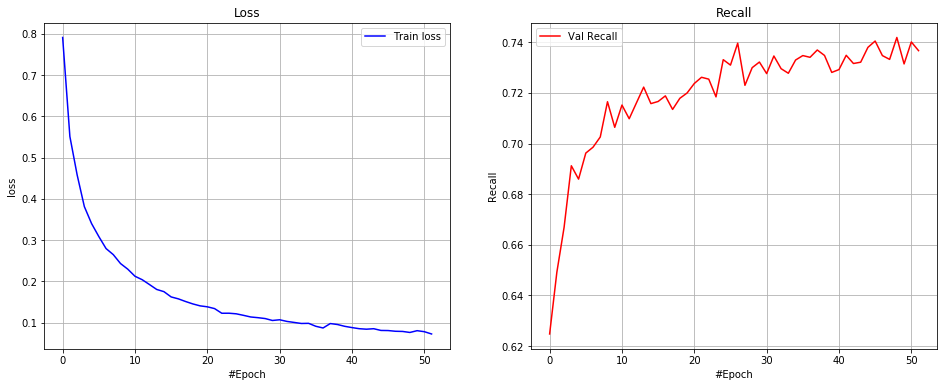

Epoch 49 of 100 took 9.809s
  training loss (in-iteration): 	0.072530
  validation loss:		0.736705
Training:


KeyboardInterrupt: 

In [41]:
for epoch_i in range(num_epochs):
    start_time = time.time() 
    print("Training:")
    train_loss = train_batches = 0    
#

    for batch in iterate_minibatches(train_data, max_batches=batches_per_epoch, max_len=max_len, batch_size=512):

        loss = compute_loss(*batch)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.cpu().numpy()[0]
#            train_mae += compute_mae(reference, prediction).data.cpu().numpy()[0]
        train_batches += 1


    train_loss_history.append(train_loss / train_batches)
#        train_mae_history.append(train_mae / train_batches)

    print("Validation:")
    val_loss = val_batches = 0
#    model.train(False)

    for batch in iterate_minibatches(val_data, shuffle=False, max_len=max_len, volatile=True):

        loss = compute_recall(*batch)

        val_loss += loss.data.cpu().numpy()[0]
#            val_mae += compute_mae(reference, prediction).data.cpu().numpy()[0]
        val_batches += 1

    val_loss_history.append(val_loss / val_batches)
#        val_mae_history.append(val_mae / val_batches)        



    display.clear_output(wait=True)
    #plt.figure(figsize=(8, 6))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
    ax1.set_title("Loss")
    ax1.set_xlabel("#Epoch")
    ax1.set_ylabel("loss")
    ax1.plot(train_loss_history, 'b', label='Train loss')
#        ax1.plot(val_loss_history, 'r', label='Val loss')
    #ax1.plot(ewma(np.array(train_loss), span=10),'r',label='ewm val loss')
    ax1.legend(loc='best')
    ax1.grid()
    #ax1.set_ylim(0, 1)

    ax2.set_title("Recall")
    ax2.set_xlabel("#Epoch")
    ax2.set_ylabel("Recall")
#        ax2.plot(train_mae_history, 'b', label='Train mae')
    ax2.plot(val_loss_history, 'r', label='Val Recall')
    #ax2.plot(ewma(np.array(val_loss), span=10),'r',label='ewm val acc')
    ax2.legend(loc='best')
    ax2.grid()    
    #ax2.set_ylim(2000, 10000)

    plt.show() 


    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch_i + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration): \t{:.6f}".format(train_loss_history[-1]))
    print("  validation loss:\t\t{:.6f}".format(val_loss_history[-1]))

#        print("  training mae (in-iteration): \t{:.3f}".format(train_mae_history[-1]))
#        print("  validation mae:\t\t{:.3f}".format(val_mae_history[-1]))    